In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from random import sample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score, roc_auc_score, roc_curve, cohen_kappa_score, brier_score_loss
from sklearn.metrics import matthews_corrcoef

In [2]:
data = pd.read_csv("dat_15-09-2022_morgan_chiral_2048FP.csv")
#data

In [3]:
df = pd.DataFrame(data)
df.reset_index(drop=True, inplace=True)
df

,FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,FP10,...,FP2040,FP2041,FP2042,FP2043,FP2044,FP2045,FP2046,FP2047,FP2048,Target
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2207,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2208,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2209,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
y= df.Target
X=df.drop('Target', axis=1)

In [5]:
cat_features=list(range(0,X.shape[1]))
#print(cat_features)

In [6]:
df.Target.value_counts()

0    1109
1    1102
Name: Target, dtype: int64

In [7]:
y_train = df.Target
x_train = df.drop('Target', axis=1)

In [8]:
#transpose matrices
x_train = x_train.T
y_train = y_train.T

In [9]:
y_train.value_counts()

0    1109
1    1102
Name: Target, dtype: int64

In [10]:
#Read the validation set
v_test_data = pd.read_csv("val_15-09-2022_morgan_chiral_2048FP.csv")
v_test_data = pd.DataFrame(v_test_data)
v_test_data.shape

(367, 2049)

In [11]:
Y_v_test_data = v_test_data.Target
X_v_test_data = v_test_data.drop('Target', axis=1)

In [13]:
import xgboost as xgb
#Parameters for 1024 ds
#xgb = xgb.XGBClassifier(
#    colsample_bylevel= 0.8,
#    colsample_bytree= 0.5,
#    learning_rate= 0.0005,
#    max_delta_step= 1,
#    max_depth= 10,
#    n_estimators= 3000,
#    objective= 'binary:logistic',
#    subsample= 0.1
#)
#  reg_alpha= 0,
#  reg_lambda= 0.8,
#    min_child_weight= 1,
#scale_pos_weight= 1,
#seed= 0,
#silent= 1,
################################################################################################################
#Parameters for 2048 ds
xgb = xgb.XGBClassifier(
    colsample_bylevel= 0.1,
    colsample_bytree= 0.65,
    learning_rate= 0.0001,
    max_delta_step= 5,
    max_depth= 15,
    n_estimators= 4000,
    objective= 'binary:logistic',
    subsample= 0.1
)
################################################################################################################
#Parameters for descriptors
#xgb = xgb.XGBClassifier(
#    colsample_bylevel= 0.1,
#    colsample_bytree= 0.65,
#    learning_rate= 0.0001,
#    max_delta_step= 5,
#    max_depth= 20,
#    n_estimators= 4000,
#    objective= 'binary:logistic',
#    subsample= 0.1
#)
################################################################################################################
xgb.fit(x_train.T, y_train.T)
v_predictions = xgb.predict(X_v_test_data)
acc_train=xgb.score(x_train.T,y_train.T)*100
v_acc_test = xgb.score(X_v_test_data, Y_v_test_data)*100
print(acc_train)
print(v_acc_test)

71.09905020352781
68.66485013623979


In [15]:
from sklearn.metrics import matthews_corrcoef
print('Accuracy:%0.3f'% v_acc_test)
tn, fp, fn, tp = confusion_matrix(Y_v_test_data, v_predictions).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
print('Sensitivity:%0.3f'% sensitivity)
print('Specificity:%0.3f'% specificity)
ba = 0.5 * (sensitivity + specificity)
print('Balance accuracy:%0.3f'% ba)
mcc = matthews_corrcoef(Y_v_test_data, v_predictions)
#mcc = matthews_corrcoef(Y_test_data, v_predictions)
print('MCC: %0.3f'% mcc)
r_auc_score = roc_auc_score(Y_v_test_data, v_predictions)
#r_auc_score = roc_auc_score(Y_test_data, v_predictions)
print('AUC: %0.3f' % r_auc_score)
bloss = brier_score_loss(Y_v_test_data, v_predictions)
#bloss = brier_score_loss(Y_test_data, v_predictions)
print('Brier_loss: %0.3f' % bloss)
FPR = fp/(fp+tn)
FNR = fn/(tp+fn)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)
print('False Postive rate: %0.3f' %FPR)
print('False Negative rate: %0.3f' %FNR)
print('Precision: %0.3f' %Precision)
print('Recall: %0.3f' %Recall)
f1=2*((Precision*Recall)/(Precision+Recall))
print('F1: %0.3f' %f1)
#kappa = cohen_kappa_score(Y_test_data, v_predictions)
kappa = cohen_kappa_score(Y_v_test_data, v_predictions)
print('Kappa: %0.3f' %kappa)

Accuracy:68.665
Sensitivity:0.605
Specificity:0.726
Balance accuracy:0.665
MCC: 0.319
AUC: 0.665
Brier_loss: 0.313
False Postive rate: 0.274
False Negative rate: 0.395
Precision: 0.514
Recall: 0.605
F1: 0.556
Kappa: 0.316


In [16]:
cf =(confusion_matrix(Y_v_test_data, v_predictions))
print(classification_report(Y_v_test_data, v_predictions))

              precision    recall  f1-score   support

           0       0.79      0.73      0.76       248
           1       0.51      0.61      0.56       119

    accuracy                           0.69       367
   macro avg       0.65      0.67      0.66       367
weighted avg       0.70      0.69      0.69       367



<AxesSubplot:xlabel='Predicted Value', ylabel='True Value'>

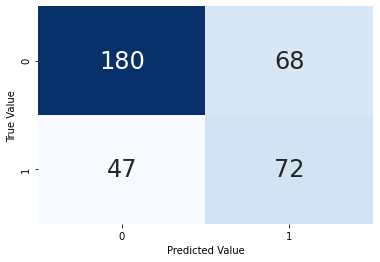

In [17]:
cf_plt =sns.heatmap(cf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
cf_plt.set(xlabel = "Predicted Value", ylabel ="True Value")
cf_plt

In [18]:
r_probs = [0 for _ in range(len(Y_v_test_data))]
xgb_prob = xgb.predict_proba(X_v_test_data)
xgb_prob = xgb_prob[:,1]
#xgb_prob

In [19]:
prediction_val=xgb.predict(X_v_test_data)

In [20]:
prediction_val=pd.DataFrame(prediction_val)

In [21]:
prediction_val.to_csv("XGB_2048_Valitation_Prediction.csv")

In [22]:
r_auc_score = roc_auc_score(Y_v_test_data, xgb_prob)
r_auc_score_1 = roc_auc_score(Y_v_test_data,r_probs)
print(r_auc_score)
fpr, tpr, _ = roc_curve(Y_v_test_data, xgb_prob)
rfpr, rtpr, _ = roc_curve(Y_v_test_data, r_probs)

0.6929384657088642


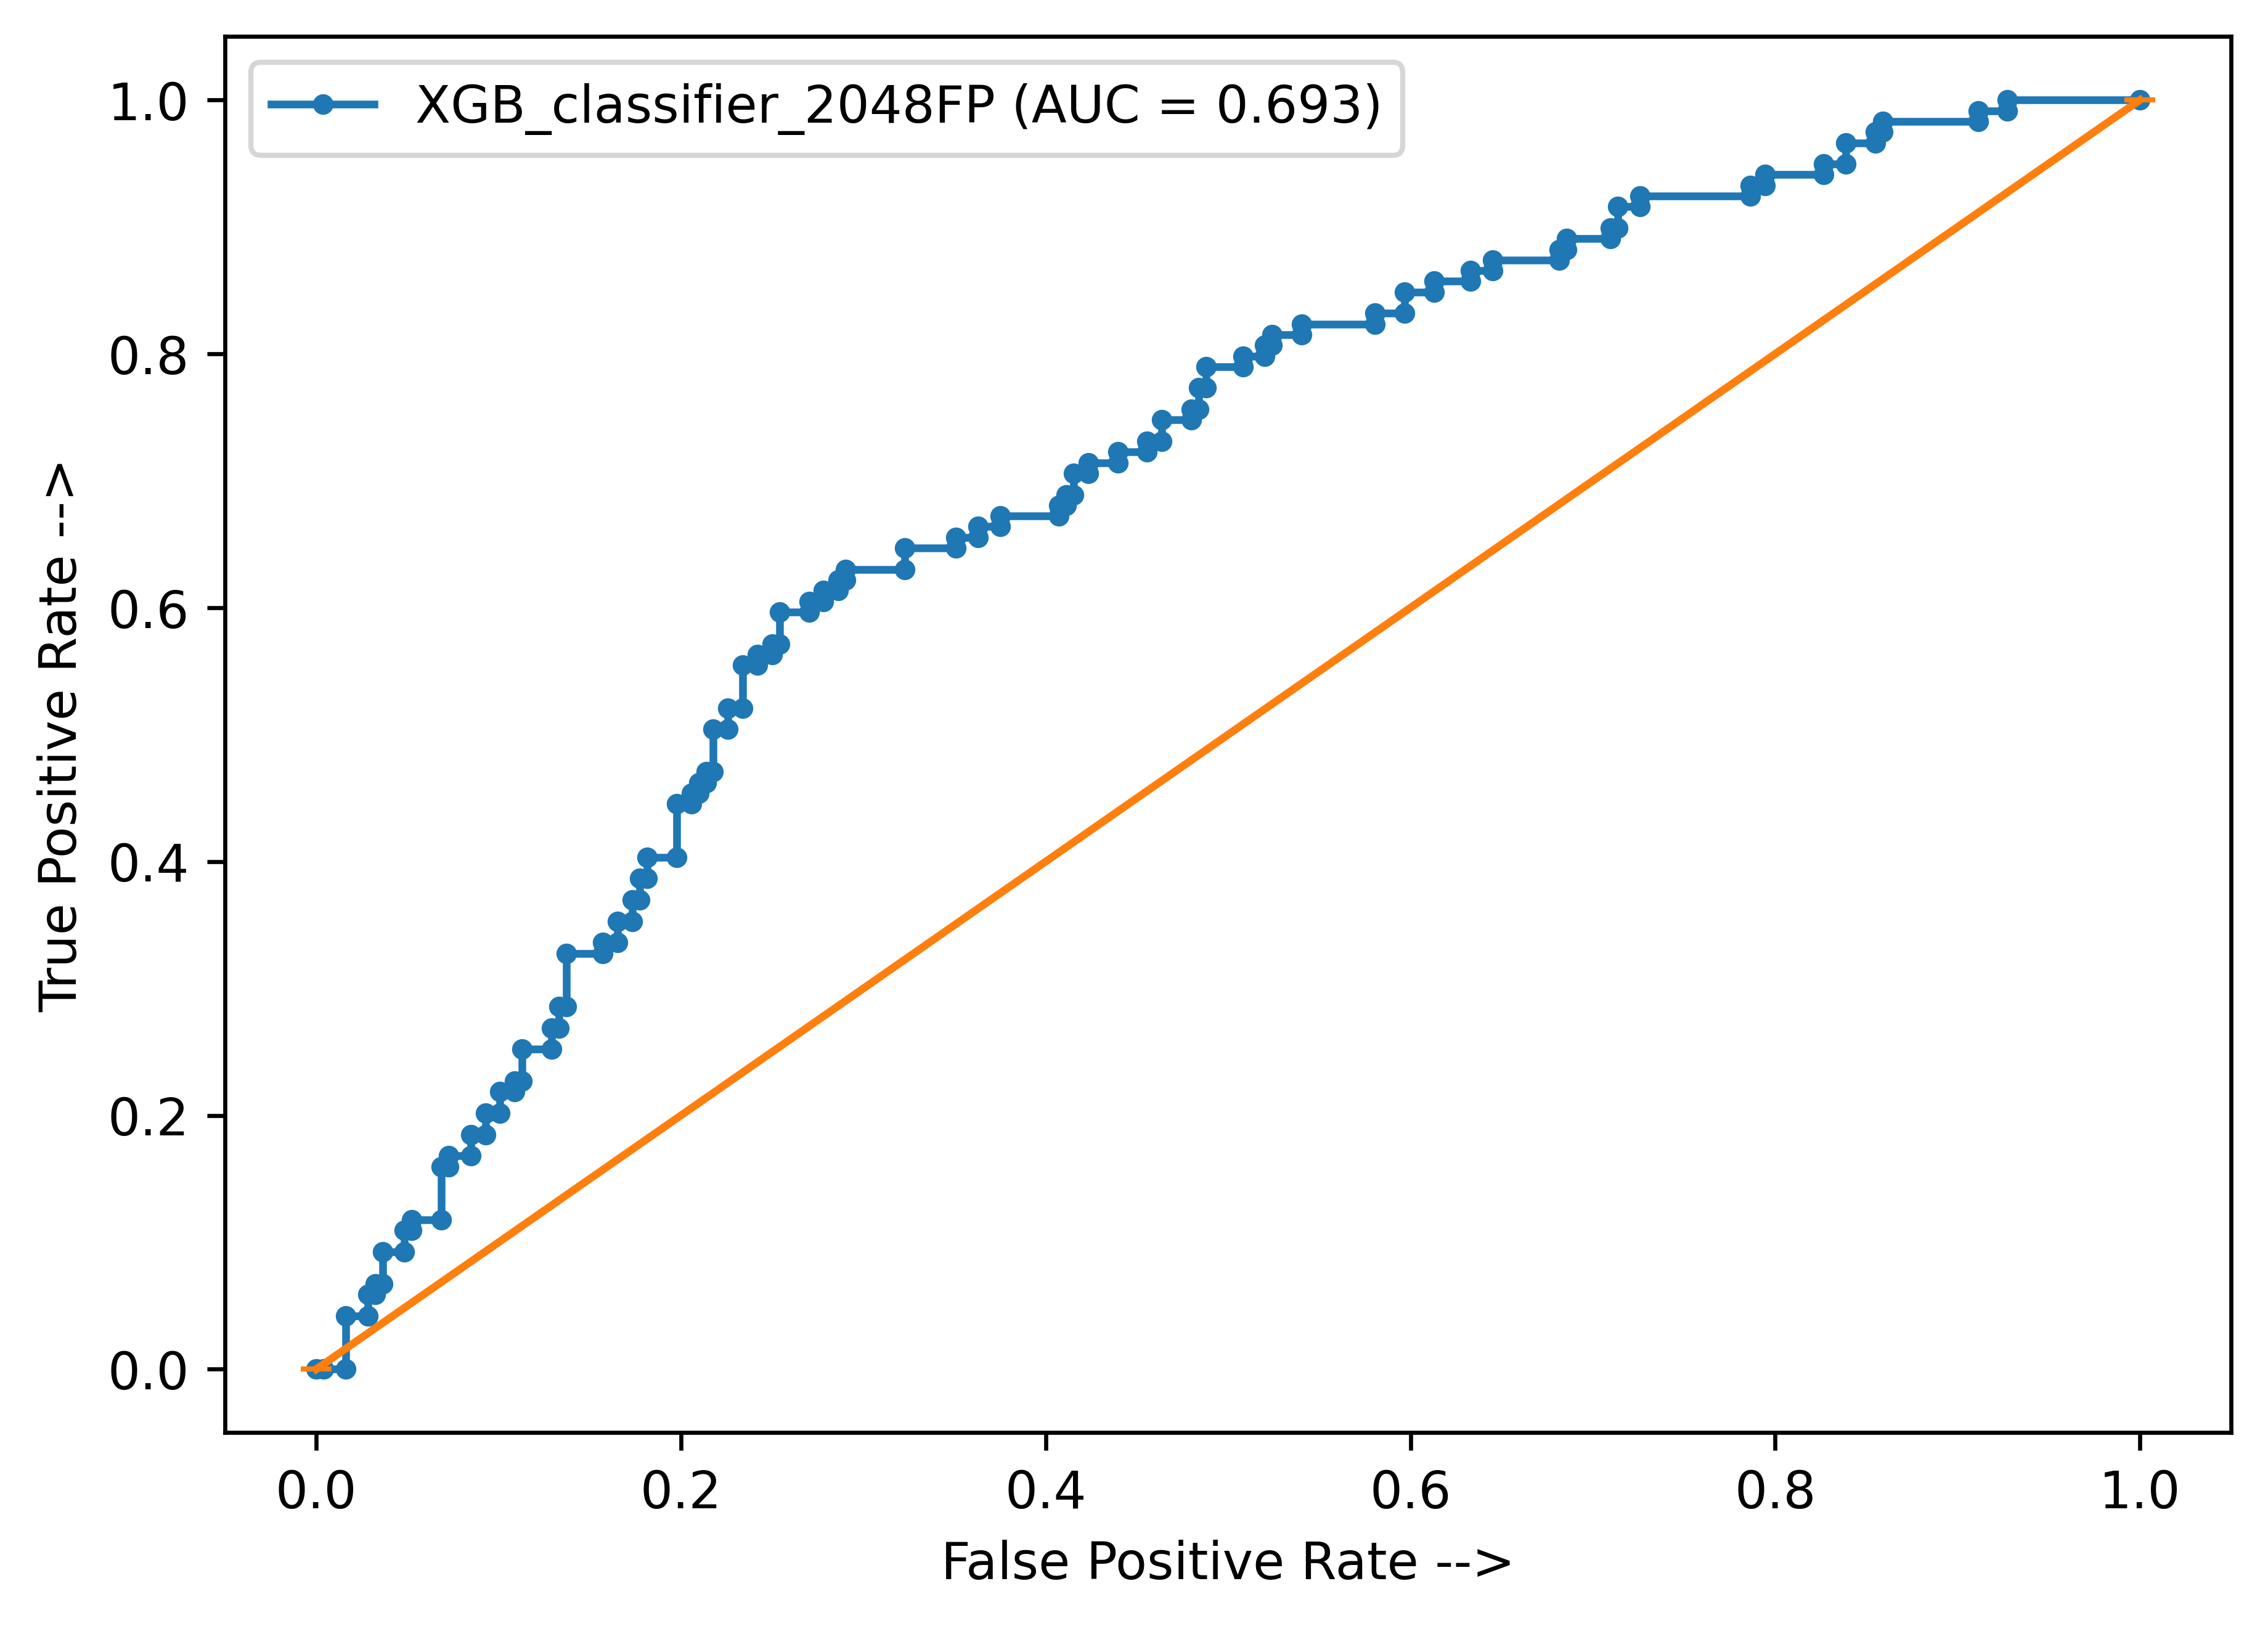

In [23]:
plt.figure(figsize=(7, 5), dpi=600)
plt.plot(fpr, tpr, marker='.', label='XGB_classifier_2048FP (AUC = %0.3f)' % r_auc_score)
plt.plot(rfpr, rtpr, marker='_' % r_auc_score_1)
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')
plt.legend()
plt.show()
#plt.savefig('XGB_AUC.png', dpi=600, bbox_inches='tight')

In [24]:
#Read external set
external_data = pd.read_csv("cyclic_ind_16-09-2022_morgan_chiral_2048FP.csv")
data_for_screening = pd.DataFrame(external_data)
#data_for_screening

In [25]:
#test external data
test_prob = xgb.predict_proba(data_for_screening)
test_prob_F = pd.DataFrame(test_prob)
test_prob_F.to_csv('XGB_2048FP_External_probability.csv')

In [26]:
prediction_ext=xgb.predict(data_for_screening)
prediction_ext=pd.DataFrame(prediction_ext)
prediction_ext.to_csv("XGB_2048_External_Prediction.csv")

##Cross-validation AUC

In [27]:
from sklearn.metrics import RocCurveDisplay

In [28]:
from scipy import interp
from sklearn.metrics import roc_curve,auc
cv = StratifiedKFold(n_splits=10,shuffle=False)

<ipython-input-29-85a45260f18c>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-29-85a45260f18c>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-29-85a45260f18c>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-29-85a45260f18c>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-29-85a45260f18c>:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-29-85a45260f18c>:13: DeprecationWarning: scipy.interp i

<Figure size 4200x3000 with 0 Axes>

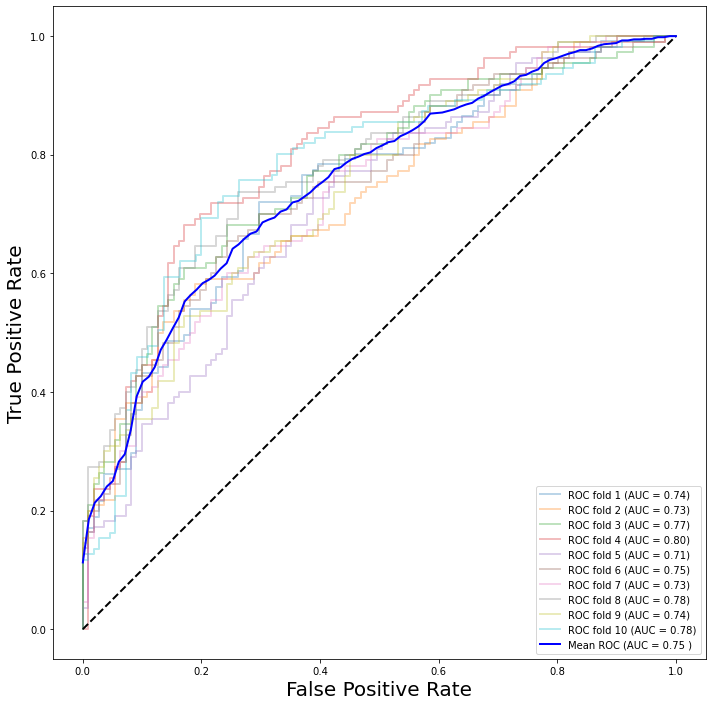

In [29]:
# plot k fold ROC
plt.figure(figsize=(7, 5), dpi=600)
x_train = x_train.T
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x_train,y_train):
    prediction = xgb.fit(x_train.iloc[train],y_train.iloc[train]).predict_proba(x_train.iloc[test])
    fpr, tpr, t = roc_curve(y_train.iloc[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.legend(loc="lower right")
plt.show()
#plt.savefig('CrossVal-AUC_CB_1024.png', dpi=600, bbox_inches='tight')

In [ ]:
##Y-randomization

In [30]:
accuracy_list = []
mcc_list = []

for i in range(50):
    y_train = y_train.sample(frac=1, replace=False, random_state=i)
    xgb.fit(x_train, y_train)
    scrmb_predictions = xgb.predict(X_v_test_data)
    print(i)
    accuracy = roc_auc_score(Y_v_test_data, scrmb_predictions)
    accuracy_list.append(accuracy)
    mcc_v = matthews_corrcoef(Y_v_test_data, scrmb_predictions)
    mcc_list.append(mcc_v)
print(accuracy_list)
print(mcc_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[0.5656343182434264, 0.5945208728652752, 0.6368765248034698, 0.46562415288696124, 0.4669625914882081, 0.4708254269449715, 0.4816007047980483, 0.5096570886419084, 0.5607549471401464, 0.5061330984006506, 0.44427690431011124, 0.47755150447275685, 0.40412374627270264, 0.4357210626185958, 0.512503388452155, 0.5968758471130388, 0.49923759826511255, 0.5219232854432095, 0.4446157495256168, 0.4806011114123068, 0.5397296015180266, 0.5590776633233938, 0.46948698834372465, 0.44597113038763897, 0.5481499051233397, 0.4247933044185417, 0.606278801843318, 0.5015756302521008, 0.5261419083762537, 0.459575765790187, 0.42831729465979945, 0.5495052859853619, 0.4558823529411764, 0.583779479533749, 0.523956356736243, 0.48378625643805906, 0.564448359989157, 0.5089963404716725, 0.47672133369476827, 0.4666406885334779, 0.3883335592301437, 0.4054791271347248, 0.4925284629981

/home/acdsd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 1.0)]

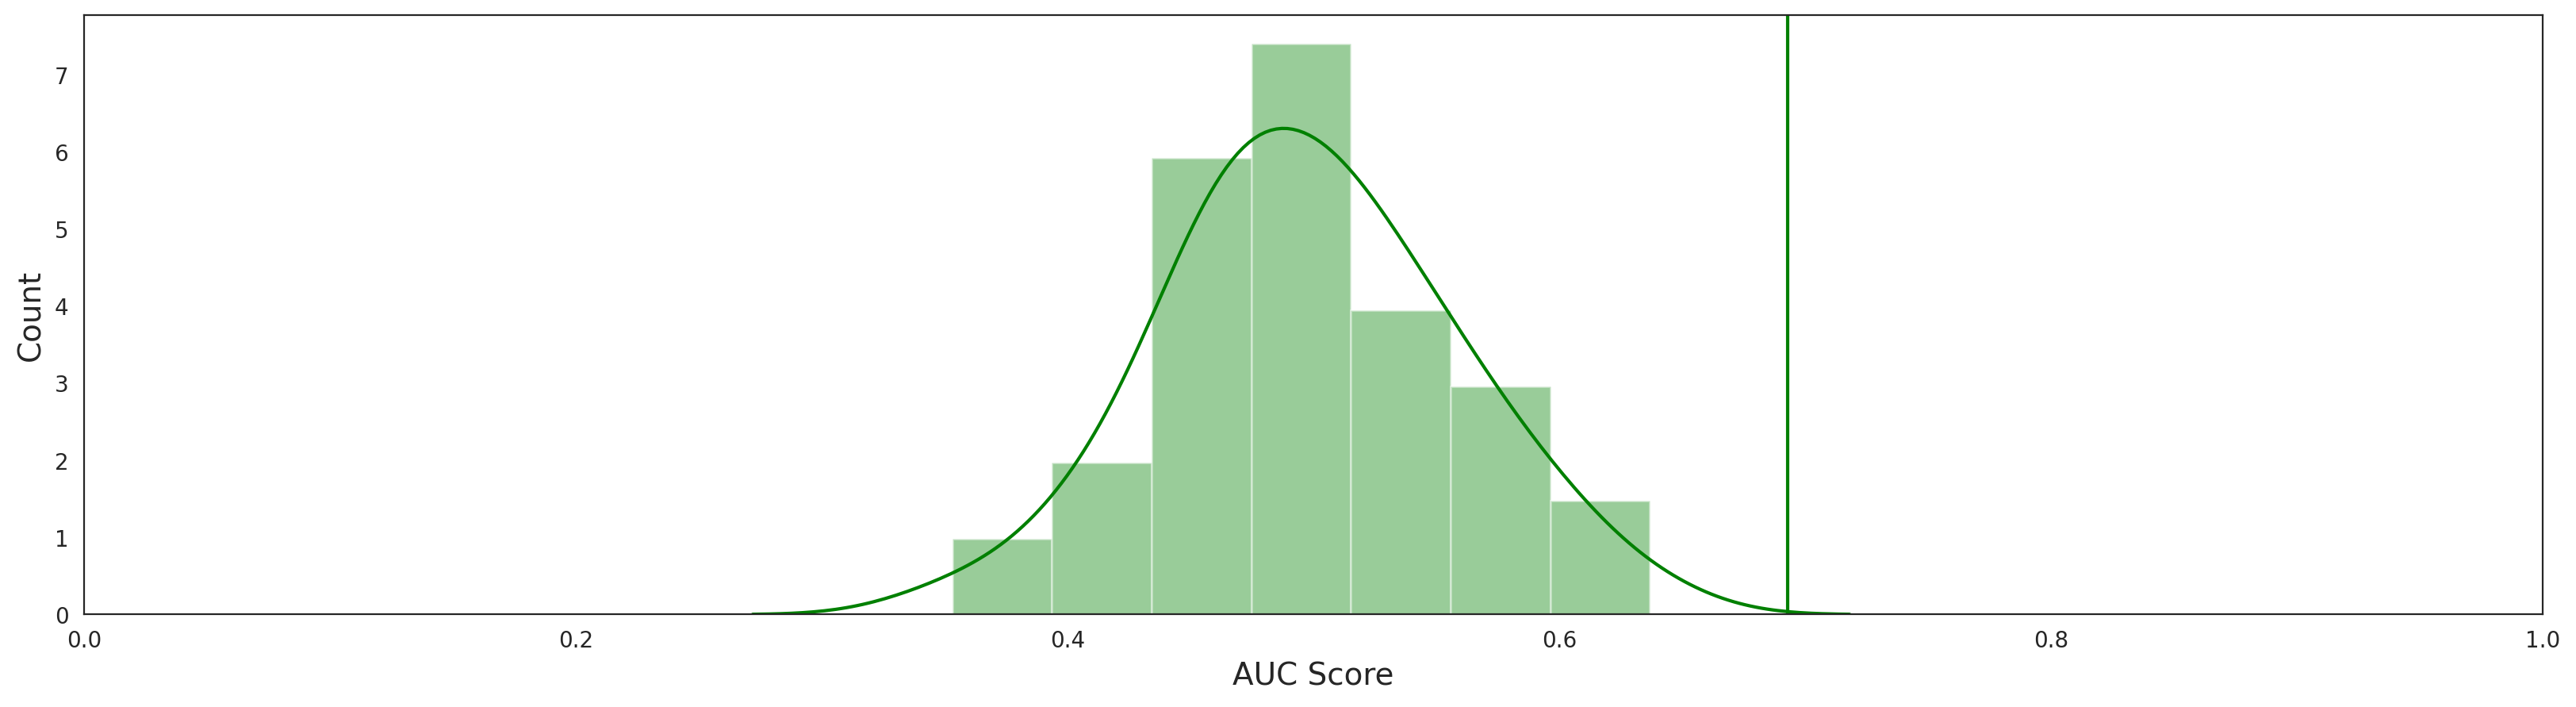

In [31]:
r_auc_score2 = roc_auc_score(Y_v_test_data, scrmb_predictions)
sns.set_style("white")
plt.figure(figsize = (20, 5), dpi=200) 
ax = sns.distplot(accuracy_list, color="green")
plt.axvline(r_auc_score, color="green")
plt.xlabel("AUC Score", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
ax.set(xlim=(0, 1))
#plt.savefig('CatBoost_scrambling_plot.png', dpi=600, bbox_inches='tight')

/home/acdsd/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[(0.0, 1.0)]

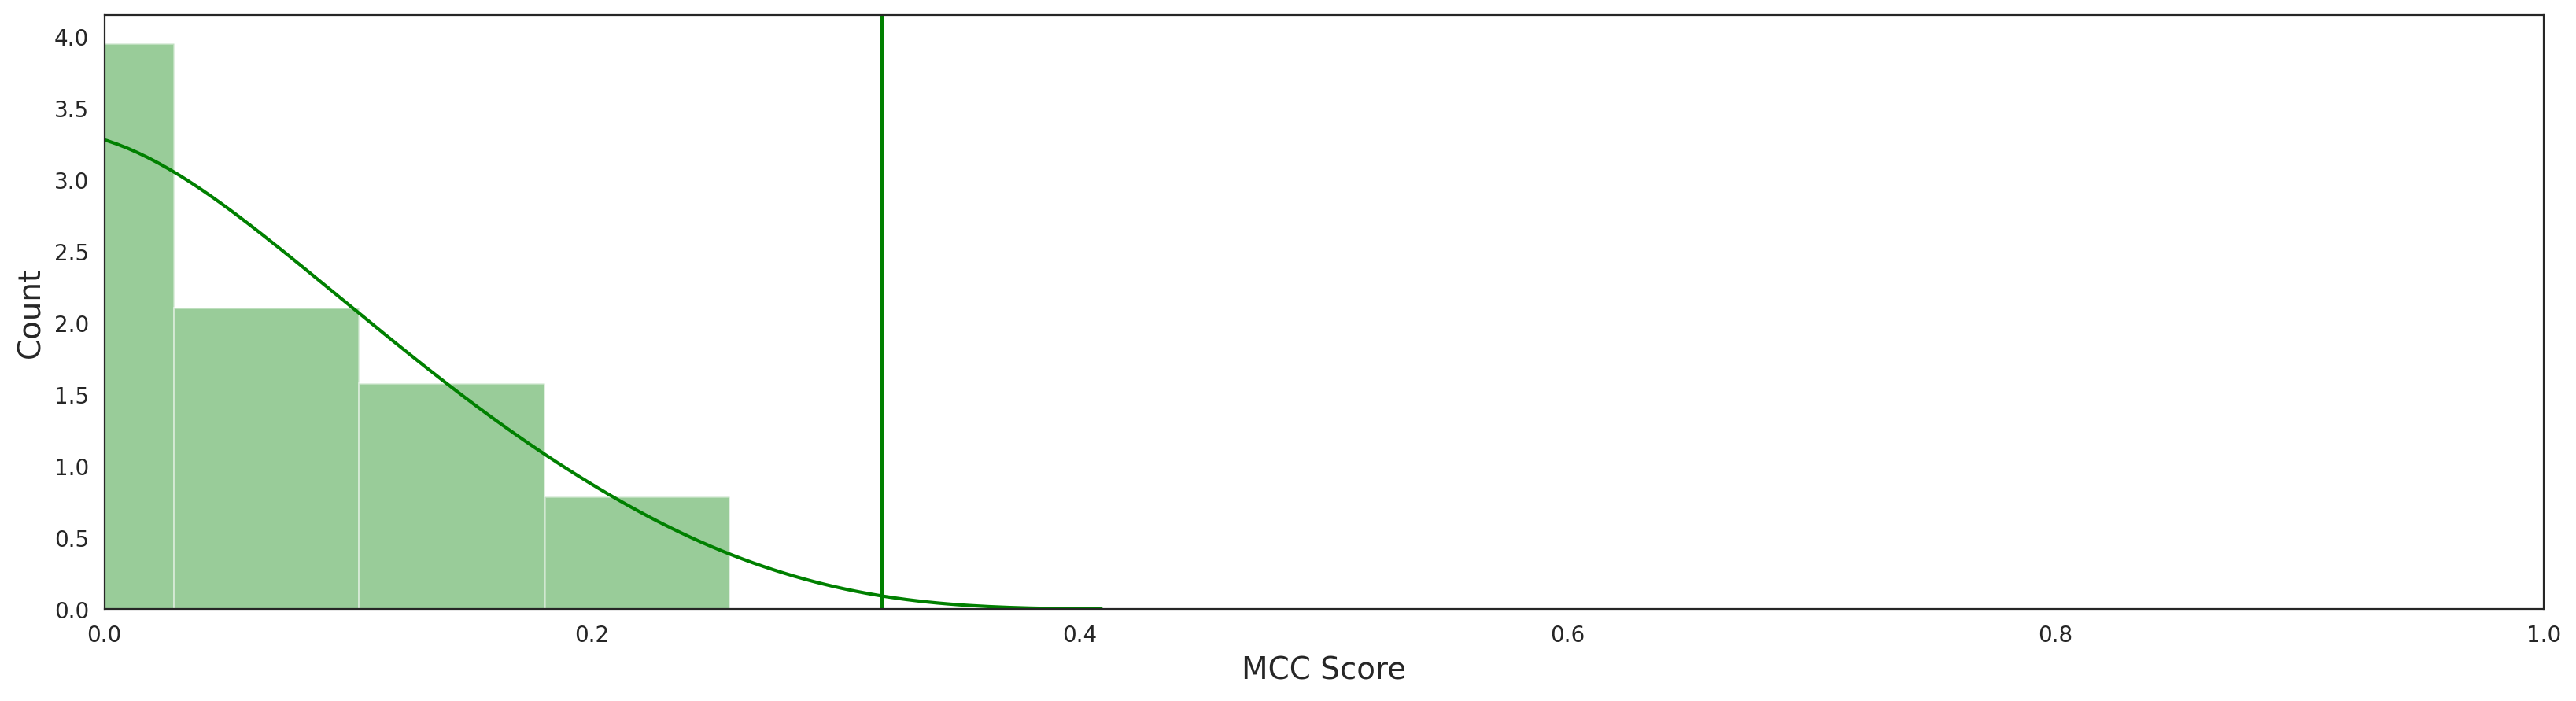

In [32]:
mcc2 = matthews_corrcoef(Y_v_test_data, scrmb_predictions)
sns.set_style("white")
plt.figure(figsize = (20, 5), dpi=200) 
ax = sns.distplot(mcc_list, color="green")
plt.axvline(mcc, color="green")
plt.xlabel("MCC Score", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
ax.set(xlim=(0, 1))
#plt.savefig('CB_MCC_plot.png', dpi=600, bbox_inches='tight')

In [2]:
accuracy_list = [0.5656343182434264, 0.5945208728652752, 0.6368765248034698, 0.46562415288696124, 0.4669625914882081, 0.4708254269449715, 0.4816007047980483, 0.5096570886419084, 0.5607549471401464, 0.5061330984006506, 0.44427690431011124, 0.47755150447275685, 0.40412374627270264, 0.4357210626185958, 0.512503388452155, 0.5968758471130388, 0.49923759826511255, 0.5219232854432095, 0.4446157495256168, 0.4806011114123068, 0.5397296015180266, 0.5590776633233938, 0.46948698834372465, 0.44597113038763897, 0.5481499051233397, 0.4247933044185417, 0.606278801843318, 0.5015756302521008, 0.5261419083762537, 0.459575765790187, 0.42831729465979945, 0.5495052859853619, 0.4558823529411764, 0.583779479533749, 0.523956356736243, 0.48378625643805906, 0.564448359989157, 0.5089963404716725, 0.47672133369476827, 0.4666406885334779, 0.3883335592301437, 0.4054791271347248, 0.4925284629981025, 0.5123339658444023, 0.50914882081865, 0.5404072919490377, 0.35304283003523984, 0.45401870425589586, 0.4953747628083492, 0.5345283274600162]
def Average(lst):
    return sum(lst) / len(lst)
#print(acc_list)
average = Average(accuracy_list)
  
# Printing average of the list
print("Average of the accuracy list =", round(average, 3))

Average of the accuracy list = 0.498


In [3]:
mcc_list = [0.1240023928194681, 0.17753381794121045, 0.25629299064351846, -0.06481093518553754, -0.06298163188720031, -0.0559371259347938, -0.03446077688887172, 0.018123807623841057, 0.11398020532529635, 0.01148385476085576, -0.10601057817994573, -0.042624957117284375, -0.17975753093239735, -0.12035483700998137, 0.023861850784232377, 0.18163165963446687, -0.001431382221975993, 0.04119587921668936, -0.10479875562772559, -0.036623597426531804, 0.07543813165285423, 0.11118212476386286, -0.05773709357159186, -0.10117179109378359, 0.0902516423675028, -0.14104636800211917, 0.20110204773714366, 0.0030452737790598837, 0.04931965804214307, -0.07607701453586944, -0.13514788899458322, 0.09418148660437867, -0.08274042403188067, 0.15742938386903313, 0.045137884657606334, -0.030377300895248913, 0.12069356940002603, 0.016883757628525616, -0.04363327115163577, -0.06247256523360969, -0.20914454923992035, -0.17753381794121045, -0.014033413463357914, 0.023619547318178627, 0.017248844258349074, 0.0760451297854353, -0.2752092589316051, -0.08862037343855435, -0.00866949273973549, 0.06480056129366328]
def Average(lst):
    return sum(lst) / len(lst)
#print(mcc_list)
average = Average(mcc_list)
  
# Printing average of the list
print("Average of the mcc list =", round(average, 3))

Average of the mcc list = -0.004


In [ ]:
external_data = pd.read_csv("IND_07-09-2022_morgan_chiral_1024FP.csv")
data_for_screening = pd.DataFrame(external_data)

In [ ]:
test_prob = xgb.predict_proba(data_for_screening)
test_prob_F = pd.DataFrame(test_prob)
test_prob_F.to_csv('XGB1024_probability_FP.csv')